# **LOAD LIBRARIES**

In [1]:
!pip install torchaudio -q --no-deps
!pip install speechbrain -q
!pip install spectralcluster -q
!pip install pyannote.metrics -q
!pip install gdown -q

     |████████████████████████████████| 1.9MB 29.6MB/s 
     |████████████████████████████████| 358kB 32.1MB/s 
     |████████████████████████████████| 1.2MB 47.8MB/s 
     |████████████████████████████████| 645kB 44.3MB/s 
     |████████████████████████████████| 102kB 13.3MB/s 
     |████████████████████████████████| 552kB 45.2MB/s 
     |████████████████████████████████| 51kB 7.6MB/s 
     |████████████████████████████████| 51kB 8.5MB/s 
     |████████████████████████████████| 61kB 9.5MB/s 
     |████████████████████████████████| 133kB 42.0MB/s 


In [2]:
# Download util module
!gdown --id 1XltkNas1LTOck62GIDYT0WcPDPGZEo7P

# Download DEC module
!gdown --id 1FWIRF2Kq6JB0fFHwjkZmVfEuGq0-SSC5

# Download optimalSpeaker.py
!gdown --id 1hbepzjAxHTQS5QoAlKNP9zK0nMxdjauJ

# Download baselineMethods.py
!gdown --id 1RQkezkiXa5DVFHE7g4UKE2v8vcmgJFpm

Downloading...
From: https://drive.google.com/uc?id=1XltkNas1LTOck62GIDYT0WcPDPGZEo7P
To: /content/utils.py
100% 16.8k/16.8k [00:00<00:00, 14.8MB/s]
Downloading...
From: https://drive.google.com/uc?id=1FWIRF2Kq6JB0fFHwjkZmVfEuGq0-SSC5
To: /content/DEC.py
100% 10.1k/10.1k [00:00<00:00, 16.5MB/s]
Downloading...
From: https://drive.google.com/uc?id=1hbepzjAxHTQS5QoAlKNP9zK0nMxdjauJ
To: /content/optimumSpeaker.py
100% 7.08k/7.08k [00:00<00:00, 6.12MB/s]
Downloading...
From: https://drive.google.com/uc?id=1RQkezkiXa5DVFHE7g4UKE2v8vcmgJFpm
To: /content/baselineMethods.py
100% 4.39k/4.39k [00:00<00:00, 7.30MB/s]


In [3]:
%pylab inline

Populating the interactive namespace from numpy and matplotlib


In [4]:
from __future__ import print_function, division
import numpy as np
import matplotlib.pyplot as plt
import torchaudio
import os
import torch
from torch.utils.data import Dataset, DataLoader
from speechbrain.pretrained import SpeakerRecognition
import warnings
warnings.filterwarnings('ignore')

from sklearn.cluster import KMeans, SpectralClustering
from sklearn import decomposition
from tqdm.auto import tqdm

from utils import DiarizationDataSet, get_metrics, plot_annot
import baselineMethods
from DEC import diarizationDEC

import shutil
import pandas as pd

# Download dataset

In [5]:
audio_dataset = DiarizationDataSet(dataset_name='voxconverse',
                                   window_len=1500, 
                                   window_step=750,
                                   split='test',
                                   use_oracle_vad=True)

print("\nData size:", len(audio_dataset))

Downloading...
From: https://drive.google.com/uc?id=1-Ft9RKdEv6xcR3XHlVAgMNuf0jfy08aY
To: /content/tmp.zip
1.99GB [00:28, 69.9MB/s]


Download and Extraction Complete


Downloading...
From: https://drive.google.com/uc?id=18oXqn9Zyt5tJpoEwKKztpTag-AJMQ2Sz
To: /content/tmp.zip
100%|██████████| 128k/128k [00:00<00:00, 6.50MB/s]


Download and Extraction Complete
Precomputed X-vectors exists!
Will use precomputed features...



Downloading...
From: https://drive.google.com/uc?id=1-2-AZnabTtHxLmw2DBwj4PJDGwlvFa8J
To: /content/tmp.zip
69.4MB [00:01, 56.1MB/s]


Download and Extraction Complete

Data size: 50


# Spectral - EigenGap

In [6]:
hypothesis_dir_spectral = baselineMethods.diarizationEigenGapNumSpkrs(audio_dataset, hypothesis_dir="./rttm_output_spectral/")
metric_spectral = get_metrics(audio_dataset.label_dir, hypothesis_dir_spectral)

# DEC

In [7]:
hypothesis_dir_dec = diarizationDEC(audio_dataset, hypothesis_dir="./rttm_output_dec/")
metric_dec = get_metrics(audio_dataset.label_dir, hypothesis_dir_dec)

# Compare

In [14]:
df_dec = metric_dec.report()
df_spectral = metric_spectral.report()

df_spectral = df_spectral[[df_dec.keys()[0]]]
df_dec = df_dec[[df_dec.keys()[0]]]

df_both = df_dec
df_both["DER (Spectral)"] = df_spectral[[df_dec.keys()[0]]]
df_both.columns = ["DER (DEC)", "DER (Spectral)"]

df_both["DER Difference"] = df_both["DER (Spectral)"]-df_both["DER (DEC)"]

df_both = df_both[:-1]
df_both = df_both.sort_values(by=['DER Difference'])

In [15]:
df_dec[-1:]

,DER (DEC),DER (Spectral),DER Difference
item,,,
TOTAL,11.695932,17.979152,6.28322


In [16]:
df_both

,DER (DEC),DER (Spectral),DER Difference
item,,,
ehpau,29.702110,10.777824,-18.924286
qjgpl,57.762641,40.362988,-17.399653
akthc,40.628986,28.736140,-11.892847
cqaec,37.296847,27.160742,-10.136105
pilgb,14.029515,7.609876,-6.419639
xmfzh,22.951305,19.608307,-3.342997
kbkon,3.126518,2.750121,-0.376396
vmaiq,17.741048,17.629521,-0.111527
falxo,57.071026,57.071026,0.000000


In [17]:
print("Better DER for", np.sum(df_both['DER Difference'].values>0), "examples.")
print("Poor DER for", np.sum(df_both['DER Difference'].values<0), "examples.")
print("Same DER for", np.sum(df_both['DER Difference'].values==0), "examples.")

Better DER for 35 examples.
Poor DER for 8 examples.
Same DER for 7 examples.


In [18]:
filenames = ["hgdez"] + list(df_both.index[[-1, -2, -3, 2, 1, 0]])


---------------------------
DEC
---------------------------



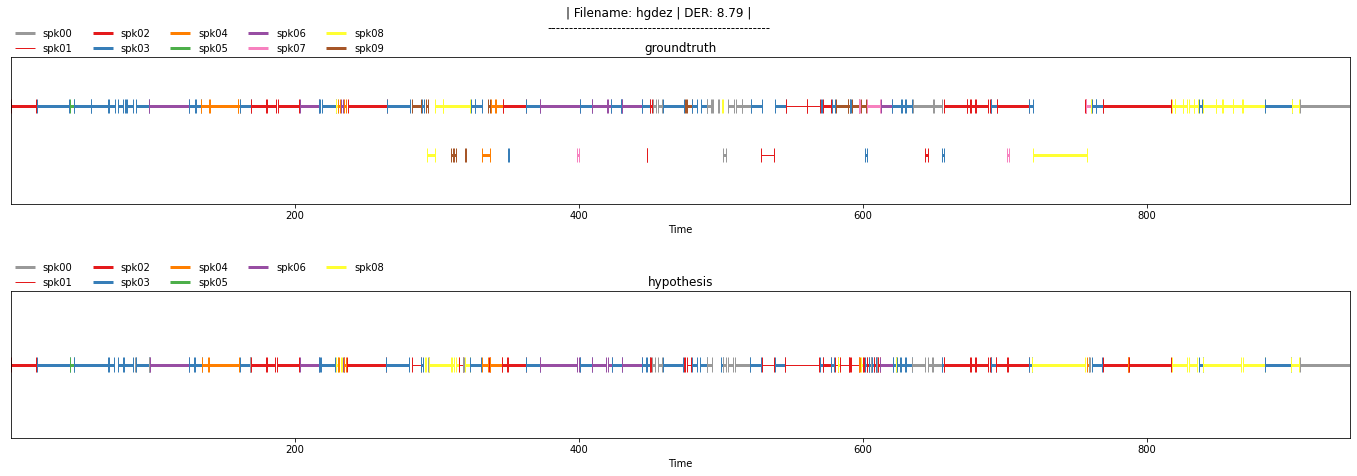


---------------------------
Spectral
---------------------------



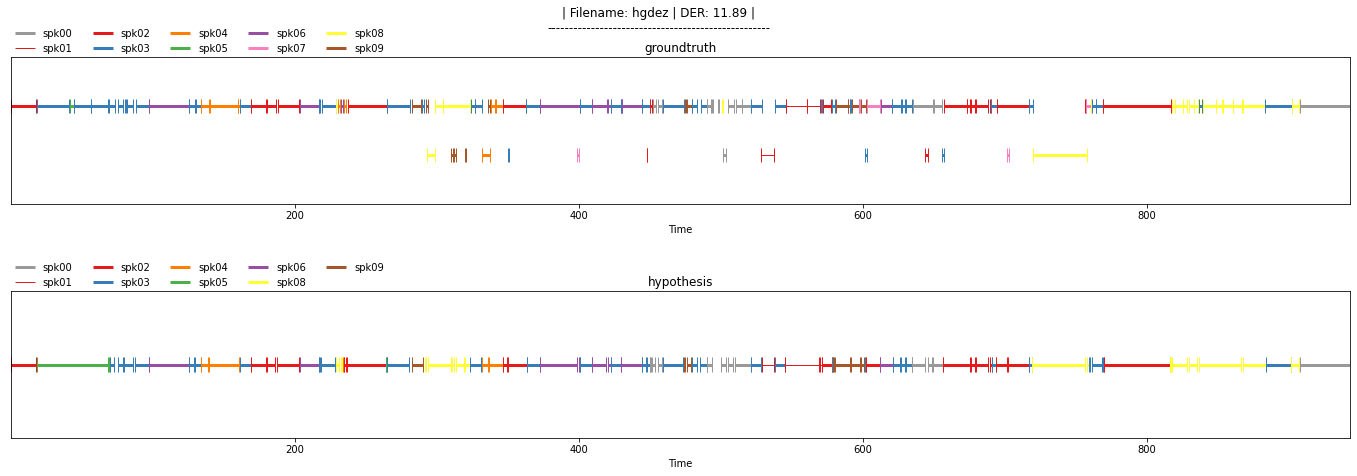


---------------------------
DEC
---------------------------



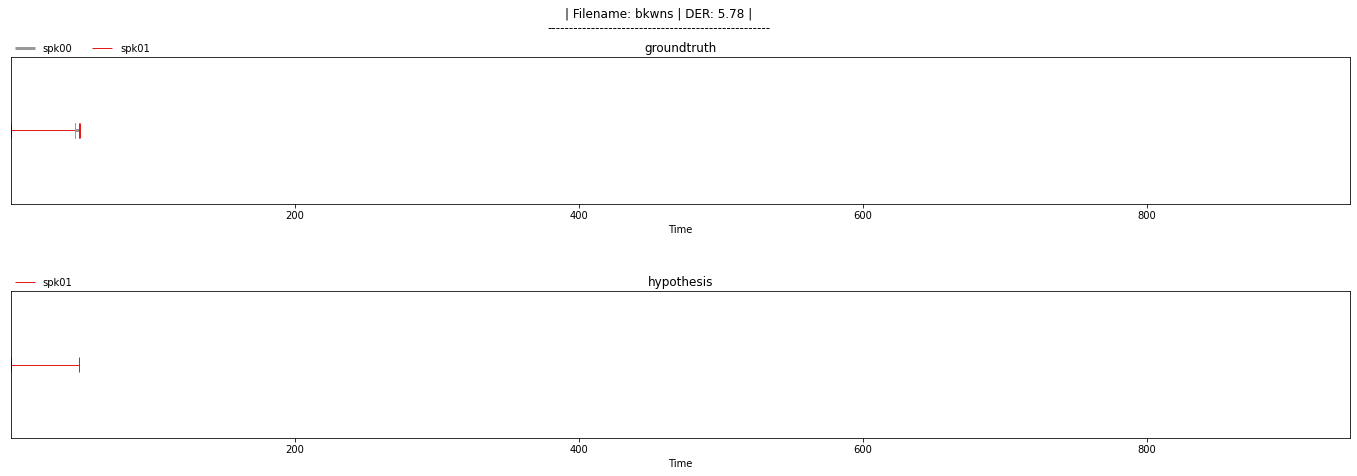


---------------------------
Spectral
---------------------------



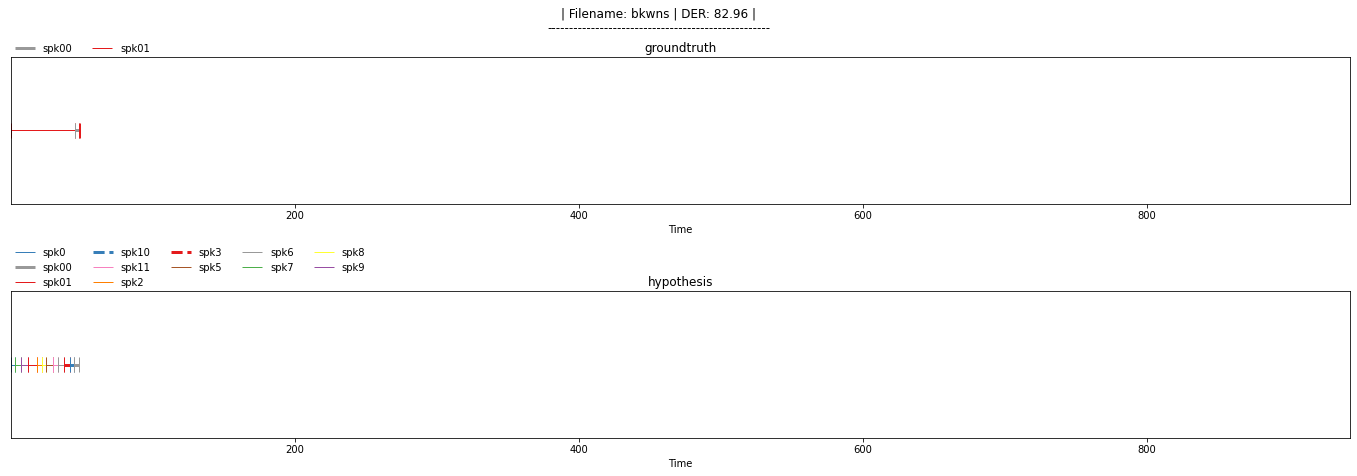


---------------------------
DEC
---------------------------



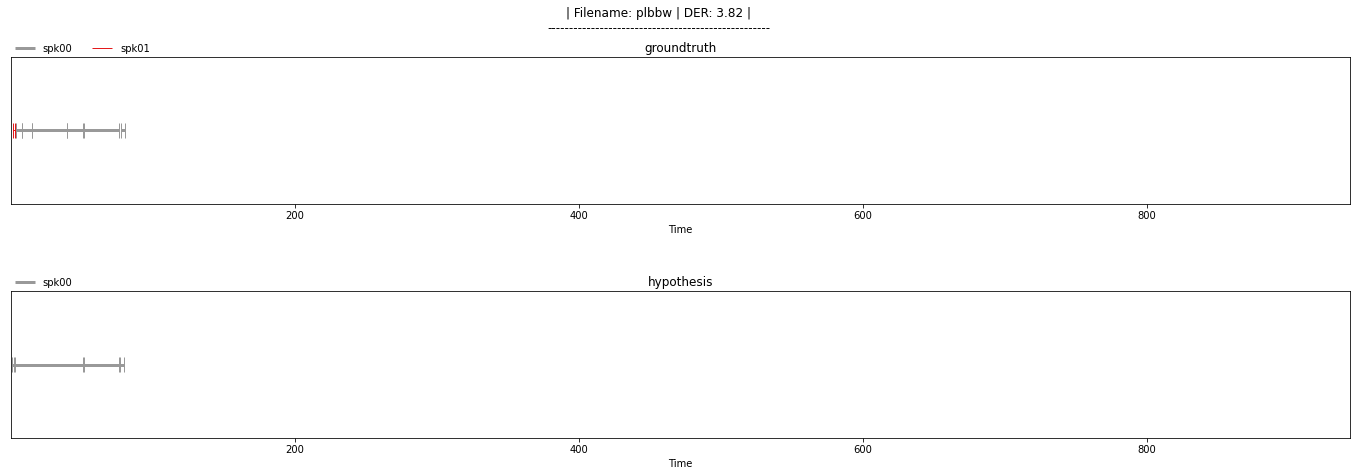


---------------------------
Spectral
---------------------------



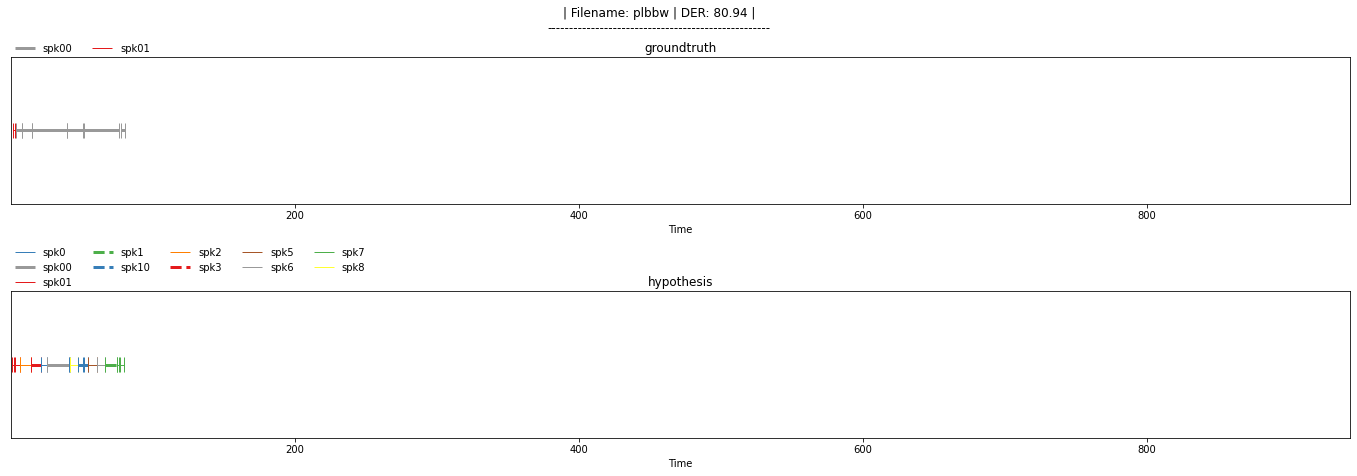


---------------------------
DEC
---------------------------



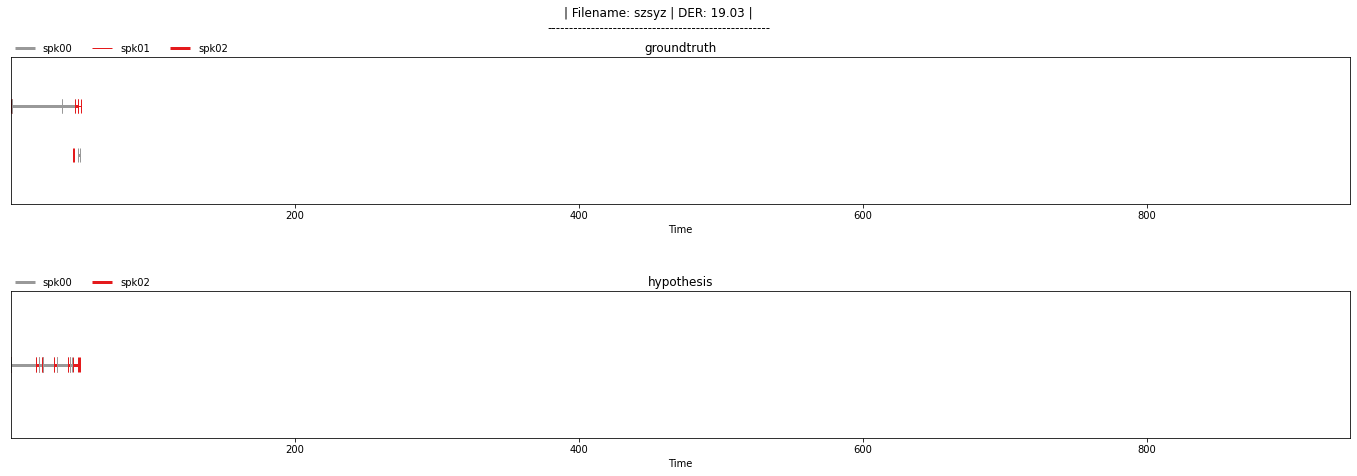


---------------------------
Spectral
---------------------------



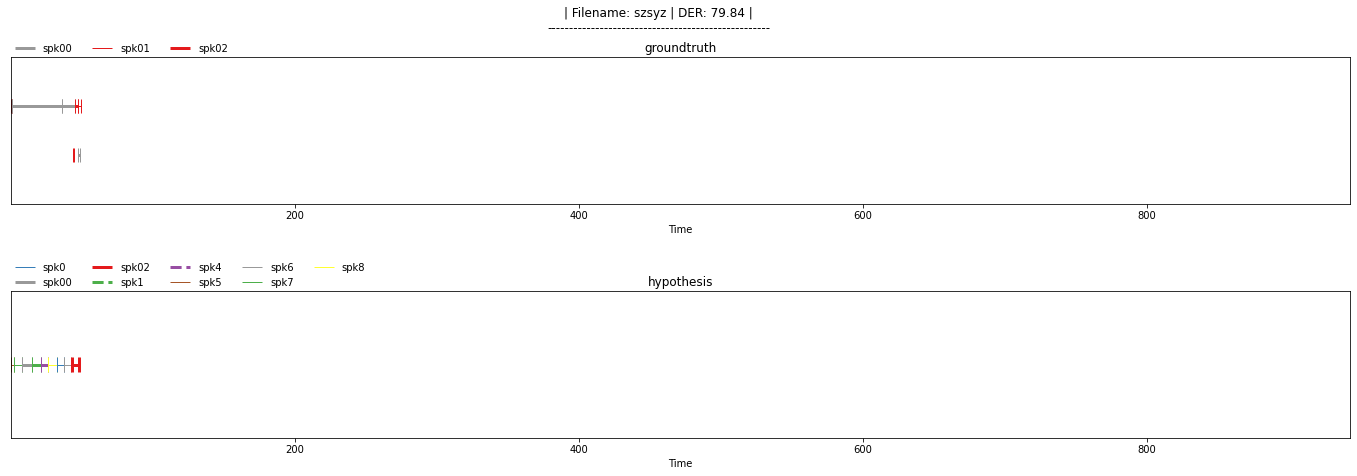


---------------------------
DEC
---------------------------



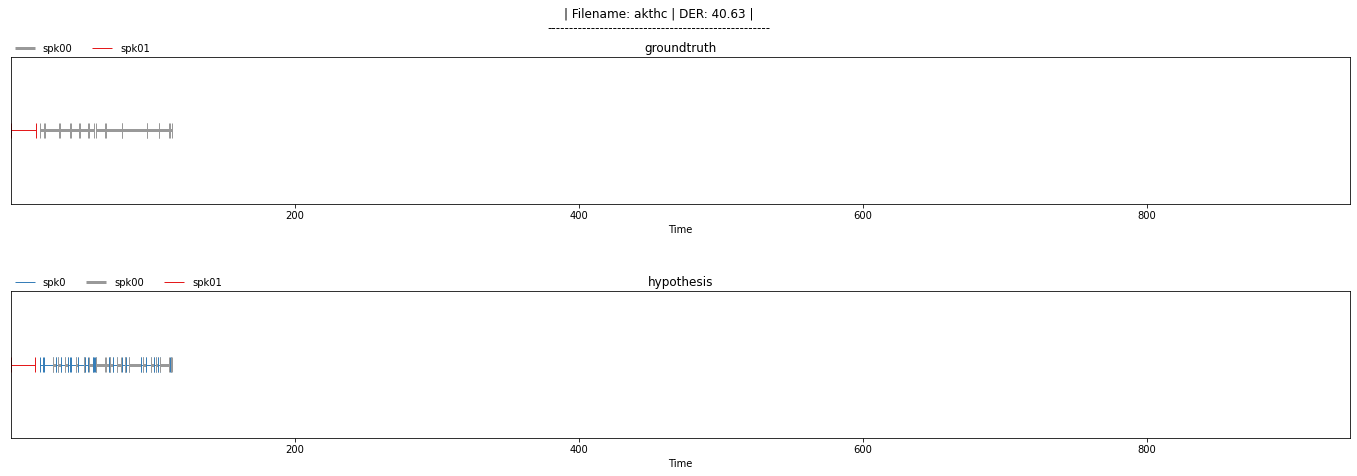


---------------------------
Spectral
---------------------------



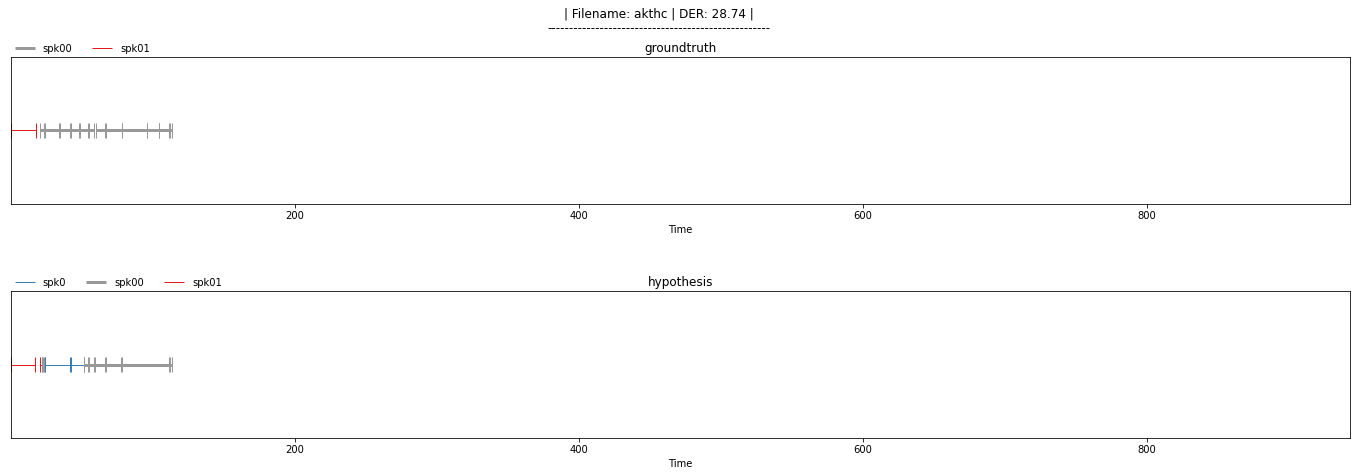


---------------------------
DEC
---------------------------



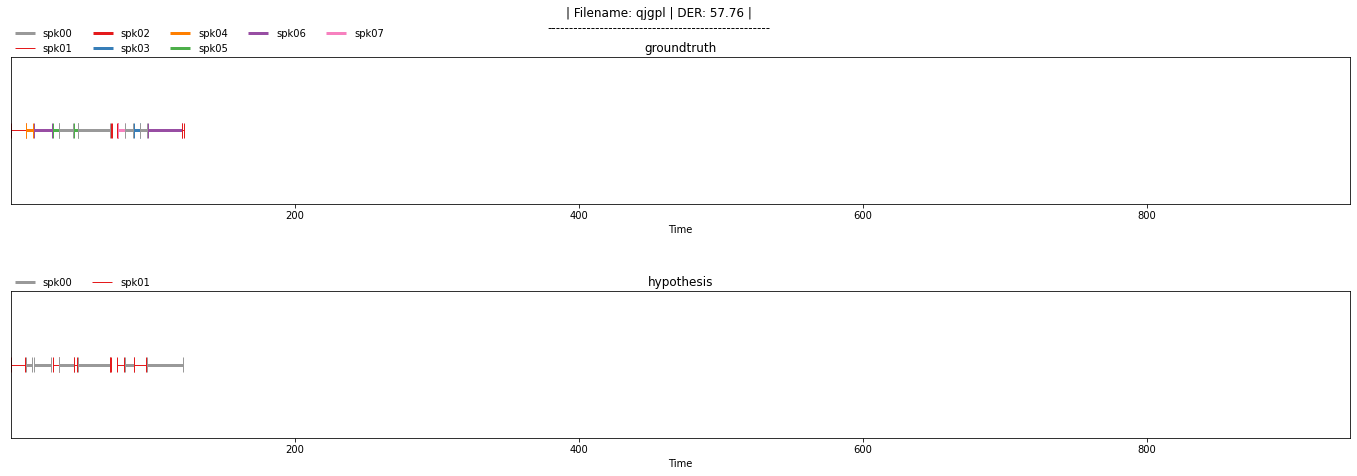


---------------------------
Spectral
---------------------------



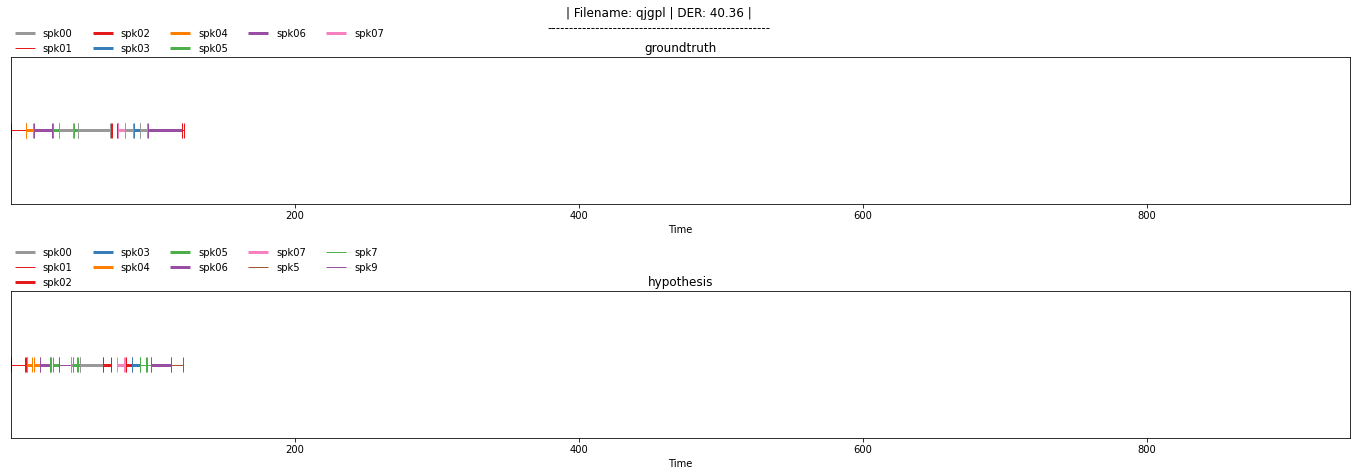


---------------------------
DEC
---------------------------



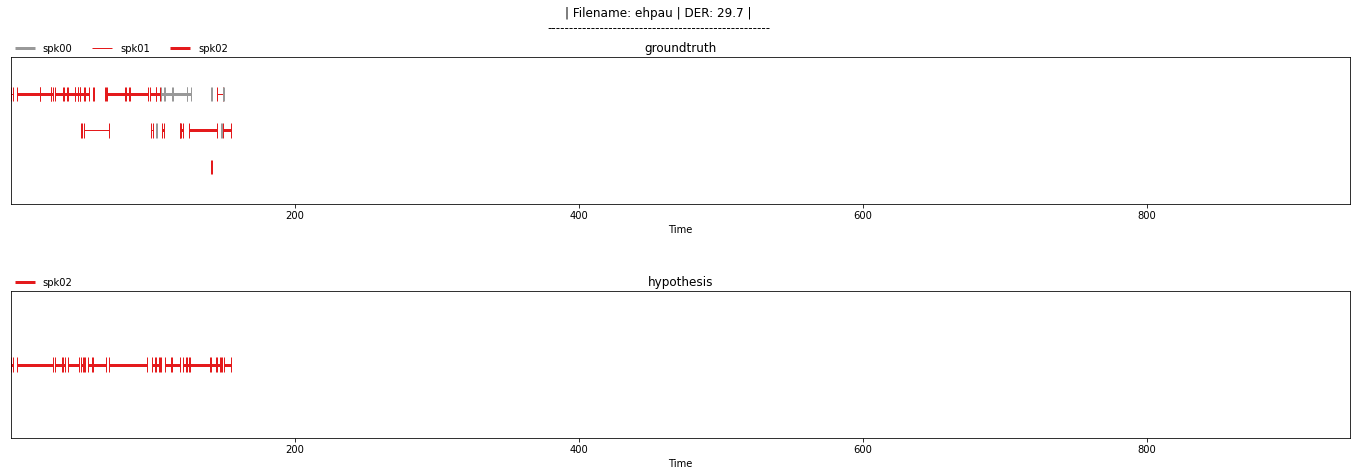


---------------------------
Spectral
---------------------------



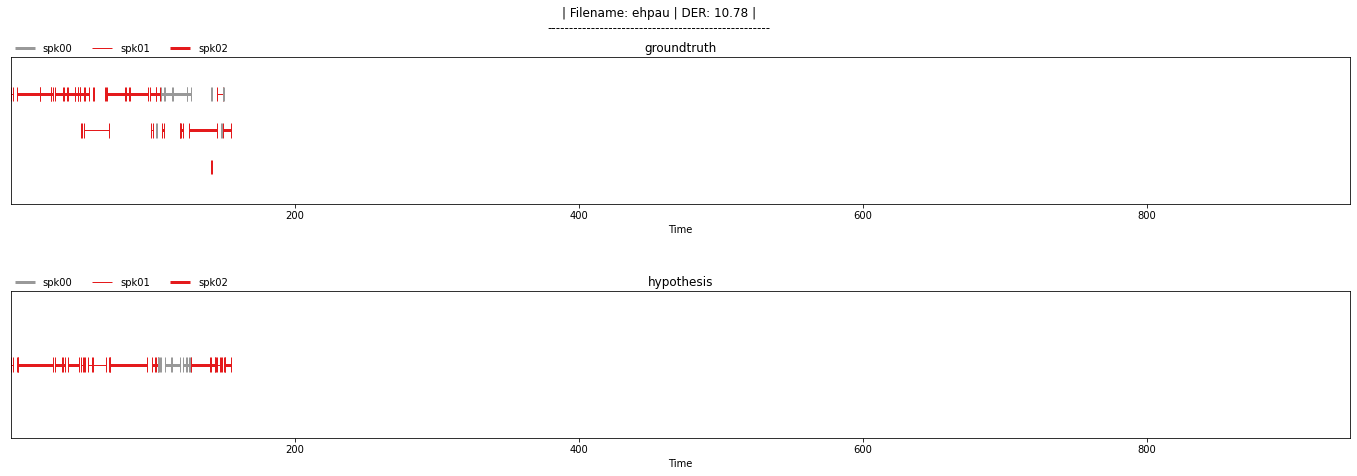

In [19]:
for name in filenames:
    print("\n---------------------------\nDEC\n---------------------------\n")
    plot_annot(name=name, collar=0.25, skip_overlap=True, groundtruth_path=audio_dataset.label_dir, hypothesis_path=hypothesis_dir_dec)
    plt.show()

    print("\n---------------------------\nSpectral\n---------------------------\n")
    plot_annot(name=name, collar=0.25, skip_overlap=True, groundtruth_path=audio_dataset.label_dir, hypothesis_path=hypothesis_dir_spectral)
    plt.show()